In [1]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import cross_validate
nltk.download("punkt")
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rstsa\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rstsa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rstsa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
stem = PorterStemmer()
lem = nltk.WordNetLemmatizer()
stop_word = nltk.corpus.stopwords.words("english")

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [4]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
print("Train dataset sample tweet:", train.loc[300,"text"])
print("Test dataset sample tweet:", test.loc[300,"text"])

Train dataset sample tweet: Shadow boxing the apocalypse
Test dataset sample tweet: My big buzzy John BlaZe. Jus Kame home from a 12 year bid. #LoveThyFamily https://t.co/xrEuoNzzbi


In [7]:
print("Shape of train dataset:", train.shape)
print("Shape of test dataset:", test.shape)

Shape of train dataset: (7613, 5)
Shape of test dataset: (3263, 4)


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In this dataset I will focus on "text" and "target" columns.

In [9]:
train.drop(["id", "keyword", "location"], axis=1, inplace=True)
test.drop(["id", "keyword", "location"], axis=1, inplace=True)
print("Shape of train dataset:", train.shape)
print("Shape of test dataset:", test.shape)

Shape of train dataset: (7613, 2)
Shape of test dataset: (3263, 1)


In [10]:
train.loc[5,"text"]

'#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires'

In [11]:
def converter(x):
    """This function applies multiple tasks sequentially"""
    
    # Tokenize the words
    process_1 = word_tokenize(x.lower())
    
    # Removing "#" from text 
    process_2 = [re.sub("#", "", i) for i in process_1]
    
    # Removing non-alphanumeric strings
    process_3 = [i for i in process_2 if i.isalpha()]
    
    # Removing stopwords
    process_4 = [i for i in process_3 if i not in stop_word]
    
    # Lemmatize words
    process_5 = [lem.lemmatize(i) for i in process_4]
    
    return " ".join(process_5)

In [12]:
train["text"] = train["text"].apply(converter)
test["text"] = test["text"].apply(converter)

In [13]:
train["text"].head()

0           deed reason earthquake may allah forgive u
1                forest fire near la ronge sask canada
2    resident asked place notified officer evacuati...
3    people receive wildfire evacuation order calif...
4    got sent photo ruby alaska smoke wildfire pour...
Name: text, dtype: object

In [14]:
test["text"].head()

0                          happened terrible car crash
1    heard earthquake different city stay safe ever...
2    forest fire spot pond goose fleeing across str...
3                 apocalypse lighting spokane wildfire
4                   typhoon soudelor kill china taiwan
Name: text, dtype: object

#### Visualization 

C:\Users\rstsa\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


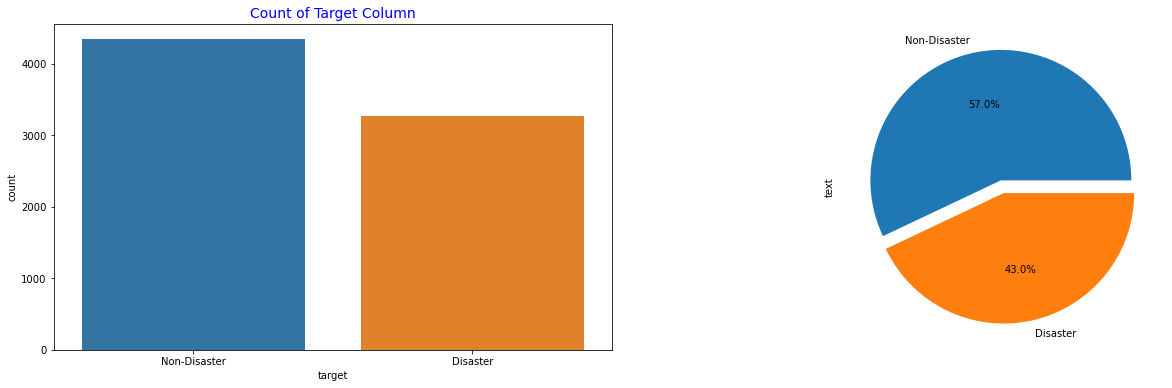

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22,6))

sns.countplot(train["target"], ax=ax[0])
ax[0].set_title("Count of Target Column", c="b", size=14)
ax[0].set_xticklabels(["Non-Disaster", "Disaster"]);

labels = ["Non-Disaster", "Disaster"]
target = train.groupby("target")["text"].count()
target.plot.pie(ax=ax[1], autopct="%.1f%%", explode=[0.05]*2, labels=labels);

<AxesSubplot:title={'center':'Top 10 Frequent Words in Tweets Not Related Disasters'}>

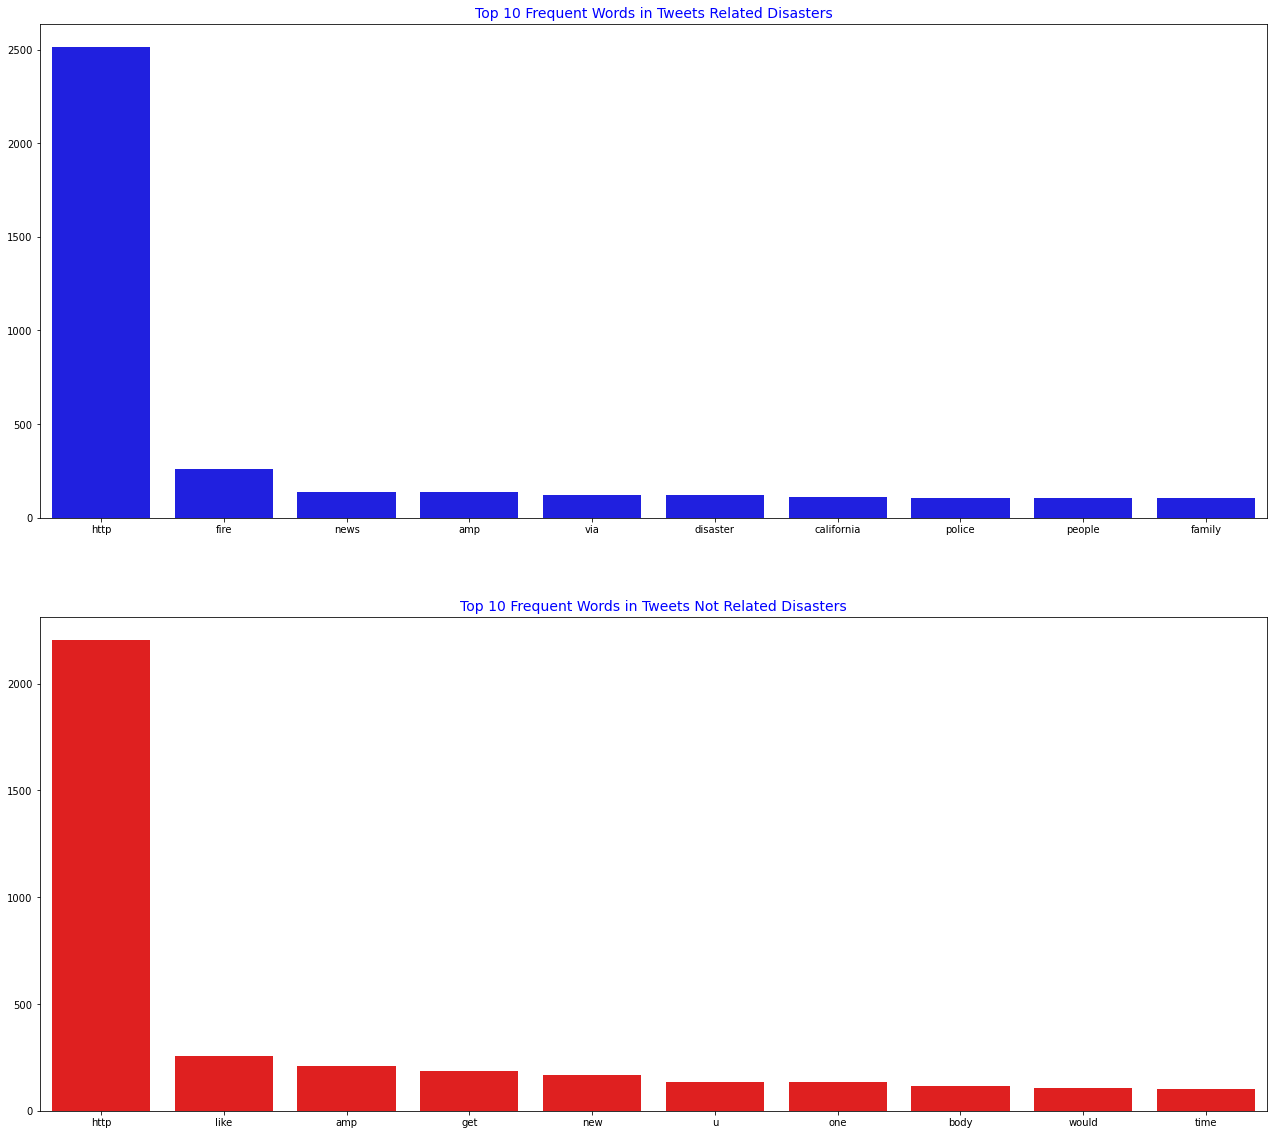

In [16]:
disasterfreq = dict()
nondisasterfreq = dict()

disaster = train[train["target"] == 1]["text"]
not_disaster = train[train["target"] == 0]["text"]

for i in " ".join(disaster).split():
    if i not in disasterfreq:
        disasterfreq[i] = 1
    else:
        disasterfreq[i] += 1
        
for i in " ".join(not_disaster).split():    
    if i not in nondisasterfreq:
        nondisasterfreq[i] = 1
    else:
        nondisasterfreq[i] += 1

disasterfreq = {k: v for k, v in sorted(disasterfreq.items(), key=lambda item: item[1], reverse=True)}  
nondisasterfreq = {k: v for k, v in sorted(nondisasterfreq.items(), key=lambda item: item[1], reverse=True)}

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(22,20))

disaster_top_10 = {k:disasterfreq[k] for k in list(disasterfreq.keys())[:10]}
ax[0].set_title("Top 10 Frequent Words in Tweets Related Disasters", c="b", size=14)
sns.barplot(x=list(disaster_top_10.keys()),y=list(disaster_top_10.values()), color="blue", ax=ax[0])

nondisaster_top_10 = {k:nondisasterfreq[k] for k in list(nondisasterfreq.keys())[:10]}
ax[1].set_title("Top 10 Frequent Words in Tweets Not Related Disasters", c="b", size=14)
sns.barplot(x=list(nondisaster_top_10.keys()), y=list(nondisaster_top_10.values()), color="red", ax=ax[1])

From the above plot, http and https are frequent in both disaster and nondisaster related tweets. However, they are not identical words. So that, they will be removed.

In [17]:
def  remove_http(x):
    
    x_new = x.split()
    if "http" in x_new:
        i = x_new.count("http")
        for j in range(i):
            x_new.remove("http")
    if "https" in x_new:
        i = x_new.count("https")
        for j in range(i):
            x_new.remove("https")
    
    return " ".join(x_new)

Text(0.5, 0, 'Words')

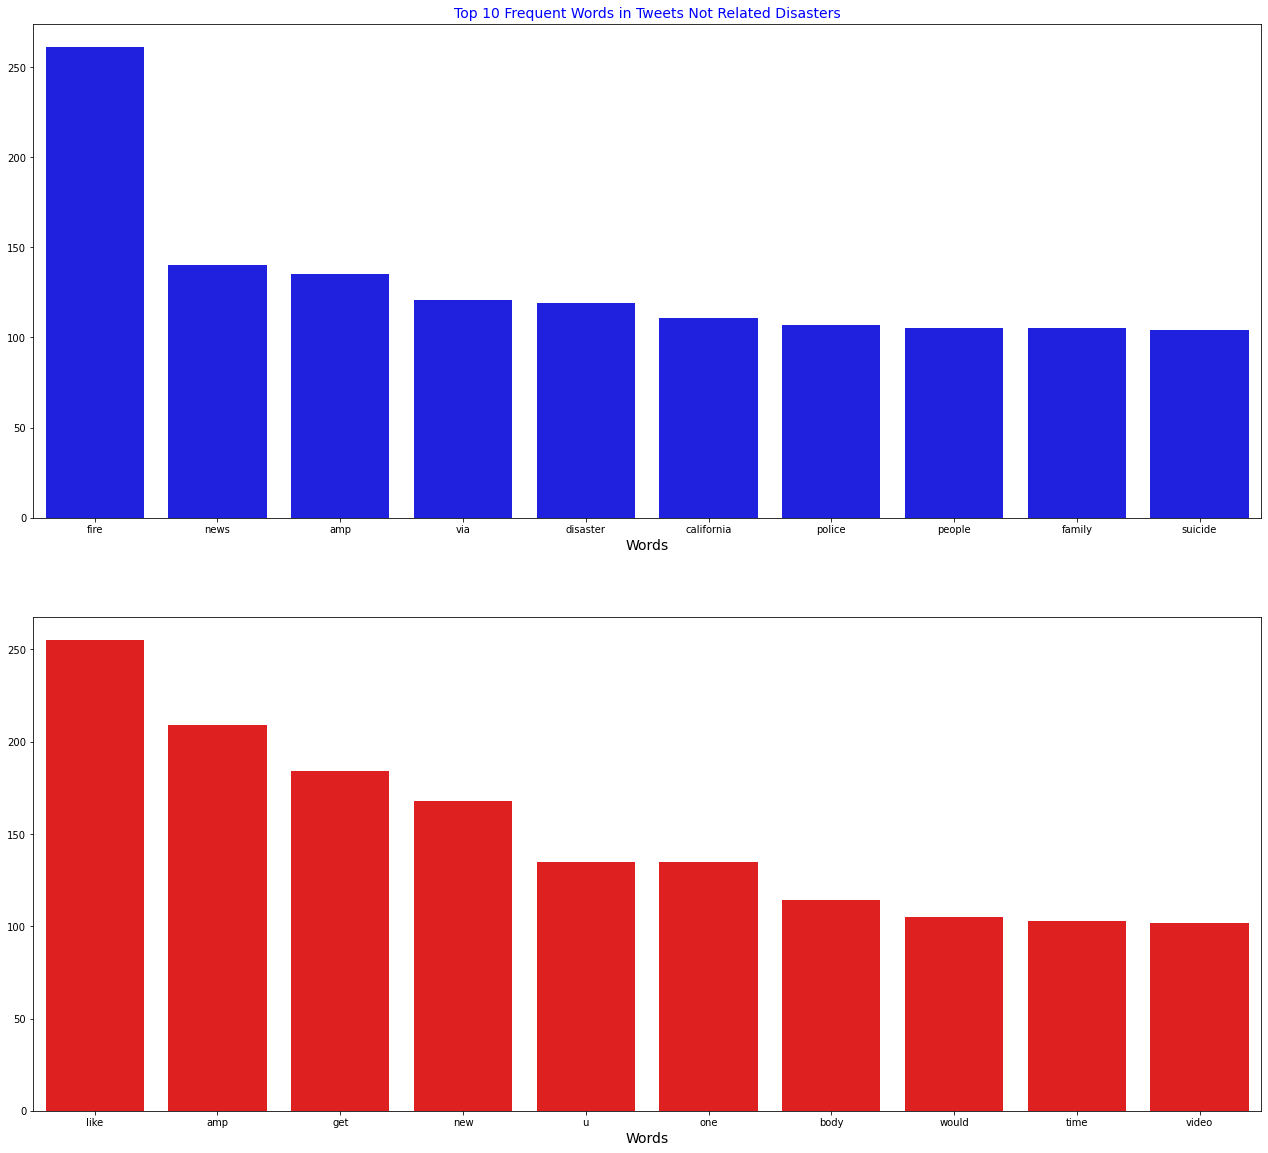

In [18]:
train["text"] = train["text"].apply(remove_http)

disasterfreq = dict()
nondisasterfreq = dict()

disaster = train[train["target"] == 1]["text"]
not_disaster = train[train["target"] == 0]["text"]

for i in " ".join(disaster).split():
    if i not in disasterfreq:
        disasterfreq[i] = 1
    else:
        disasterfreq[i] += 1
        
for i in " ".join(not_disaster).split():    
    if i not in nondisasterfreq:
        nondisasterfreq[i] = 1
    else:
        nondisasterfreq[i] += 1

disasterfreq = {k: v for k, v in sorted(disasterfreq.items(), key=lambda item: item[1], reverse=True)}  
nondisasterfreq = {k: v for k, v in sorted(nondisasterfreq.items(), key=lambda item: item[1], reverse=True)}

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(22,20))

disaster_top_10 = {k:disasterfreq[k] for k in list(disasterfreq.keys())[:10]}
ax[0].set_title("Top 10 Frequent Words in Tweets Related Disasters", c="b", size=14)
sns.barplot(x=list(disaster_top_10.keys()),y=list(disaster_top_10.values()), color="blue", ax=ax[0])
ax[0].set_xlabel("Words", size=14)

nondisaster_top_10 = {k:nondisasterfreq[k] for k in list(nondisasterfreq.keys())[:10]}
ax[0].set_title("Top 10 Frequent Words in Tweets Not Related Disasters", c="b", size=14)
sns.barplot(x=list(nondisaster_top_10.keys()), y=list(nondisaster_top_10.values()), color="red", ax=ax[1])
ax[1].set_xlabel("Words", size=14)

(-0.5, 399.5, 199.5, -0.5)

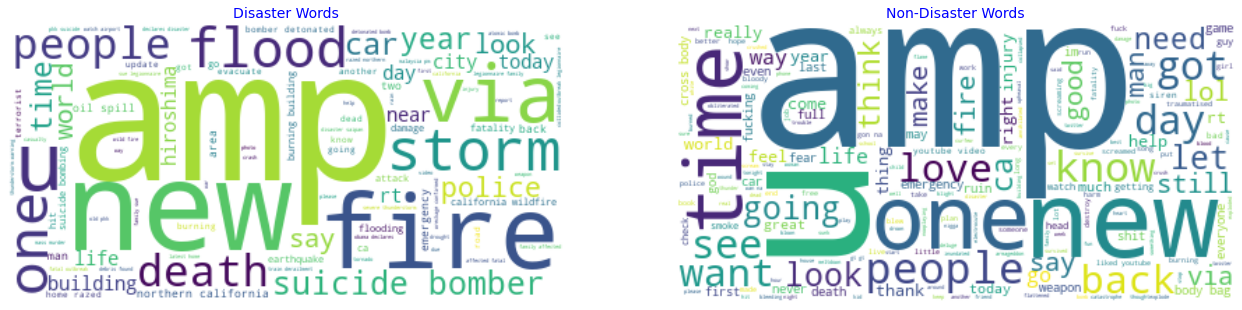

In [19]:
# WordCloud
disasterlist = " ".join(disaster)
not_disasterlist = " ".join(not_disaster)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(22,14))
wordcloud = WordCloud(background_color="white", max_words=1000)
wordcloud.generate(disasterlist)
ax[0].set_title("Disaster Words", c="blue", size=14)
ax[0].imshow(wordcloud, interpolation="bilinear")
ax[0].axis("off")

wordcloud = WordCloud(background_color="white", max_words=1000)
wordcloud.generate(not_disasterlist)
ax[1].set_title("Non-Disaster Words", c="blue", size=14)
ax[1].imshow(wordcloud, interpolation="bilinear")
ax[1].axis("off")

In [20]:
X = train["text"]
y = train["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [21]:
# CountVectorizer

countvect = CountVectorizer()
X_train_cov = countvect.fit_transform(X_train)
X_test_cov = countvect.transform(X_test)

In [22]:
# TfidfVectorizer
tfidf = TfidfVectorizer()
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [23]:
# Cross Validation Scoring

scoring = {'accuracy' : make_scorer(accuracy_score), 
           'f1_score' : make_scorer(f1_score),
           'recall' : make_scorer(recall_score)}

### Logistic Regression

In [24]:
logmodel = LogisticRegression()
logmodel.fit(X_train_cov, y_train)
y_pred_log_cov = logmodel.predict(X_test_cov)
print(confusion_matrix(y_test, y_pred_log_cov))
print("*****")
print(classification_report(y_test, y_pred_log_cov))

[[947 144]
 [221 592]]
*****
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      1091
           1       0.80      0.73      0.76       813

    accuracy                           0.81      1904
   macro avg       0.81      0.80      0.80      1904
weighted avg       0.81      0.81      0.81      1904



In [25]:
logmodel= LogisticRegression()
logmodel.fit(X_train_tfidf, y_train)
y_pred_log_tfidf = logmodel.predict(X_test_tfidf)
print(confusion_matrix(y_test, y_pred_log_tfidf))
print("*****")
print(classification_report(y_test, y_pred_log_tfidf))

[[976 115]
 [241 572]]
*****
              precision    recall  f1-score   support

           0       0.80      0.89      0.85      1091
           1       0.83      0.70      0.76       813

    accuracy                           0.81      1904
   macro avg       0.82      0.80      0.80      1904
weighted avg       0.82      0.81      0.81      1904



In [26]:
params_log = {"penalty":["l1", "l2", "elasticnet"],
              "C":[0.5,1,1.5],
              "solver":["newton-cg", "lbfgs", "liblinear", "sag", "saga"]}

In [27]:
log_model_countvec_rand = RandomizedSearchCV(LogisticRegression(), param_distributions=params_log, n_jobs=-1, cv=3).fit(X_train_cov, y_train)
print(log_model_countvec_rand.best_params_)

{'solver': 'saga', 'penalty': 'l2', 'C': 1.5}


C:\Users\rstsa\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [28]:
log_model_tfidfvec_rand = RandomizedSearchCV(LogisticRegression(), param_distributions=params_log, n_jobs=-1, cv=3).fit(X_train_tfidf, y_train)
print(log_model_tfidfvec_rand.best_params_)

{'solver': 'saga', 'penalty': 'l2', 'C': 1.5}


In [29]:
logmodel= LogisticRegression(solver="saga", penalty="l2", C=1.5)
logmodel.fit(X_train_cov, y_train)
y_pred_log_cov_tun = logmodel.predict(X_test_cov)
print(confusion_matrix(y_test, y_pred_log_cov_tun))
print("*****")
print(classification_report(y_test, y_pred_log_cov_tun))

[[931 160]
 [215 598]]
*****
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1091
           1       0.79      0.74      0.76       813

    accuracy                           0.80      1904
   macro avg       0.80      0.79      0.80      1904
weighted avg       0.80      0.80      0.80      1904



C:\Users\rstsa\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


In [30]:
logmodel = LogisticRegression(solver="saga", penalty="l2", C=2)
logmodel.fit(X_train_tfidf, y_train)
y_pred_log_tfidf_tun = logmodel.predict(X_test_tfidf)
print(confusion_matrix(y_test, y_pred_log_tfidf_tun))
print("*****")
print(classification_report(y_test, y_pred_log_tfidf_tun))

[[960 131]
 [223 590]]
*****
              precision    recall  f1-score   support

           0       0.81      0.88      0.84      1091
           1       0.82      0.73      0.77       813

    accuracy                           0.81      1904
   macro avg       0.81      0.80      0.81      1904
weighted avg       0.81      0.81      0.81      1904



In [31]:
log_countvec_score = cross_validate(LogisticRegression(solver="saga", penalty="l2", C=0.5), X_train_cov, y_train, cv=5, n_jobs=-1, scoring=scoring)
log_countvec_cv_accuracy = log_countvec_score["test_accuracy"].mean()
log_countvec_cv_f1_score = log_countvec_score["test_f1_score"].mean()
log_countvec_cv_recall = log_countvec_score["test_recall"].mean()
print("Accuracy score for Logistic Regression with CountVectorized: ", log_countvec_cv_accuracy)
print("F1 score for Logistic Regression with CountVectorized:", log_countvec_cv_f1_score)
print("Recall score for Logistic Regression with CountVectorized:", log_countvec_cv_recall)

Accuracy score for Logistic Regression with CountVectorized:  0.7856033129141335
F1 score for Logistic Regression with CountVectorized: 0.730093598654845
Recall score for Logistic Regression with CountVectorized: 0.6737146689185832


In [32]:
log_tfidfvec_score = cross_validate(LogisticRegression(solver="saga", penalty="l2", C=2), X_train_tfidf, y_train, cv=5, n_jobs=-1, scoring=scoring)
log_tfidfvec_cv_accuracy = log_tfidfvec_score["test_accuracy"].mean()
log_tfidfvec_cv_f1_score = log_tfidfvec_score["test_f1_score"].mean()
log_tfidfvec_cv_recall = log_tfidfvec_score["test_recall"].mean()
print("Accuracy score for Logistic Regression with Tf-Idf: ", log_tfidfvec_cv_accuracy)
print("F1 score for Logistic Regression with Tf-Idf:", log_tfidfvec_cv_f1_score)
print("Recall score for Logistic Regression with Tf-Idf:", log_tfidfvec_cv_recall)

Accuracy score for Logistic Regression with Tf-Idf:  0.7898049303849052
F1 score for Logistic Regression with Tf-Idf: 0.7249966149866087
Recall score for Logistic Regression with Tf-Idf: 0.6436101866110311


### Random Forest Classifier

In [33]:
rfc_model = RandomForestClassifier()
rfc_model.fit(X_train_cov, y_train)
y_pred_rfc_cov = rfc_model.predict(X_test_cov)
print(confusion_matrix(y_test, y_pred_rfc_cov))
print("\n")
print(classification_report(y_test, y_pred_rfc_cov))

[[894 197]
 [248 565]]


              precision    recall  f1-score   support

           0       0.78      0.82      0.80      1091
           1       0.74      0.69      0.72       813

    accuracy                           0.77      1904
   macro avg       0.76      0.76      0.76      1904
weighted avg       0.77      0.77      0.77      1904



In [34]:
rfc_model = RandomForestClassifier()
rfc_model.fit(X_train_tfidf, y_train)
y_pred_rfc_tfidf = rfc_model.predict(X_test_tfidf)
print(confusion_matrix(y_test, y_pred_rfc_tfidf))
print("\n")
print(classification_report(y_test, y_pred_rfc_tfidf))

[[865 226]
 [228 585]]


              precision    recall  f1-score   support

           0       0.79      0.79      0.79      1091
           1       0.72      0.72      0.72       813

    accuracy                           0.76      1904
   macro avg       0.76      0.76      0.76      1904
weighted avg       0.76      0.76      0.76      1904



In [35]:
params_rfc = {"n_estimators":[50, 100, 300],
              "criterion":["gini", "entropy"],
              "min_samples_split":[2,3,4], 
              "max_features":["auto", "sqrt", "log2"]}

In [36]:
rfc_model_cov_rand = RandomizedSearchCV(RandomForestClassifier(), param_distributions=params_rfc, n_jobs=-1, cv=3).fit(X_train_cov, y_train)
print(rfc_model_cov_rand.best_params_)

{'n_estimators': 100, 'min_samples_split': 4, 'max_features': 'log2', 'criterion': 'entropy'}


In [37]:
rfc_model_tfidf_rand = RandomizedSearchCV(RandomForestClassifier(), param_distributions=params_rfc, n_jobs=-1, cv=3).fit(X_train_tfidf, y_train)
print(rfc_model_tfidf_rand.best_params_)

{'n_estimators': 100, 'min_samples_split': 4, 'max_features': 'log2', 'criterion': 'gini'}


In [38]:
rfc_model = RandomForestClassifier(n_estimators=100, min_samples_split=4, max_features="log2", criterion="entropy")
rfc_model.fit(X_train_cov, y_train)
y_pred_rfc_cov_tun = rfc_model.predict(X_test_cov)
print(confusion_matrix(y_test, y_pred_rfc_cov_tun))
print("\n")
print(classification_report(y_test, y_pred_rfc_cov_tun))

[[962 129]
 [255 558]]


              precision    recall  f1-score   support

           0       0.79      0.88      0.83      1091
           1       0.81      0.69      0.74       813

    accuracy                           0.80      1904
   macro avg       0.80      0.78      0.79      1904
weighted avg       0.80      0.80      0.80      1904



In [39]:
rfc_model = RandomForestClassifier(n_estimators=100, min_samples_split=4, max_features="log2", criterion="gini")
rfc_model.fit(X_train_tfidf, y_train)
y_pred_rfc_tfidf_tun = rfc_model.predict(X_test_tfidf)
print(confusion_matrix(y_test, y_pred_rfc_tfidf_tun))
print("\n")
print(classification_report(y_test, y_pred_rfc_tfidf_tun))

[[944 147]
 [255 558]]


              precision    recall  f1-score   support

           0       0.79      0.87      0.82      1091
           1       0.79      0.69      0.74       813

    accuracy                           0.79      1904
   macro avg       0.79      0.78      0.78      1904
weighted avg       0.79      0.79      0.79      1904



In [40]:
rfc_countvec_score = cross_validate(RandomForestClassifier(n_estimators=100, min_samples_split=4, max_features="log2", criterion="entropy"), X_train_cov, y_train, cv=5, n_jobs=-1, scoring=scoring)
rfc_countvec_cv_accuracy = rfc_countvec_score["test_accuracy"].mean()
rfc_countvec_cv_f1_score = rfc_countvec_score["test_f1_score"].mean()
rfc_countvec_cv_recall = rfc_countvec_score["test_recall"].mean()
print("Accuracy score for Random Forest Classifier with CountVectorized: ", rfc_countvec_cv_accuracy)
print("F1 score for Random Forest Classifier with CountVectorized:", rfc_countvec_cv_f1_score)
print("Recall score for Random Forest Classifier with CountVectorized:", rfc_countvec_cv_recall)

Accuracy score for Random Forest Classifier with CountVectorized:  0.789980368712117
F1 score for Random Forest Classifier with CountVectorized: 0.7239084864126084
Recall score for Random Forest Classifier with CountVectorized: 0.6407812163661352


In [41]:
rfc_tfidfvec_score = cross_validate(RandomForestClassifier(n_estimators=100, min_samples_split=4, max_features="log2", criterion="gini"), X_train_tfidf, y_train, cv=5, n_jobs=-1, scoring=scoring)
rfc_tfidfvec_cv_accuracy = rfc_tfidfvec_score["test_accuracy"].mean()
rfc_tfidfvec_cv_f1_score = rfc_tfidfvec_score["test_f1_score"].mean()
rfc_tfidfvec_cv_recall = rfc_tfidfvec_score["test_recall"].mean()
print("Accuracy score for Random Forest Classifier with Tf-Idf: ", rfc_tfidfvec_cv_accuracy)
print("F1 score for Random Forest Classifier with Tf-Idf:", rfc_tfidfvec_cv_f1_score)
print("Recall score for Random Forest Classifier with Tf-Idf:", rfc_tfidfvec_cv_recall)

Accuracy score for Random Forest Classifier with Tf-Idf:  0.7812222663930463
F1 score for Random Forest Classifier with Tf-Idf: 0.7090234857333179
Recall score for Random Forest Classifier with Tf-Idf: 0.6208418194161575


### XGBoost Classifier

In [42]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train_cov, y_train)
y_pred_xgb_cov = xgb_model.predict(X_test_cov)
print(confusion_matrix(y_test, y_pred_xgb_cov))
print("\n")
print(classification_report(y_test, y_pred_xgb_cov))

[23:55:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

C:\Users\rstsa\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[[975 116]
 [290 523]]


              precision    recall  f1-score   support

           0       0.77      0.89      0.83      1091
           1       0.82      0.64      0.72       813

    accuracy                           0.79      1904
   macro avg       0.79      0.77      0.77      1904
weighted avg       0.79      0.79      0.78      1904



In [43]:
xgb_model = XGBClassifier()
xgb_model.fit(X_train_tfidf, y_train)
y_pred_xgb_tfidf = xgb_model.predict(X_test_tfidf)
print(confusion_matrix(y_test, y_pred_xgb_tfidf))
print("\n")
print(classification_report(y_test, y_pred_xgb_tfidf))

[23:55:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[961 130]
 [295 518]]


              precision    recall  f1-score   support

           0       0.77      0.88      0.82      1091
           1       0.80      0.64      0.71       813

    accuracy                           0.78      1904
   macro avg       0.78      0.76      0.76      1904
weighted avg       0.78      0.78      0.77      1904



In [44]:
params_xgb = {'learning_rate': [0.01, 0.1],
              'max_depth': [3, 5, 7, 10],
              'min_child_weight': [1, 3, 5],
              'subsample': [0.5, 0.7],
              'colsample_bytree': [0.5, 0.7],
              'n_estimators' : [100, 200, 500]}

In [45]:
xgb_model_cov_rand = RandomizedSearchCV(XGBClassifier(), param_distributions=params_xgb, n_jobs=-1, cv=3).fit(X_train_cov, y_train)
print(xgb_model_cov_rand.best_params_)

C:\Users\rstsa\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:56:13] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'subsample': 0.7, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 7, 'learning_rate': 0.1, 'colsample_bytree': 0.7}


In [46]:
xgb_model_tfidf_rand = RandomizedSearchCV(XGBClassifier(), param_distributions=params_xgb, n_jobs=-1, cv=3).fit(X_train_tfidf, y_train)
print(xgb_model_tfidf_rand.best_params_)

C:\Users\rstsa\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:57:08] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
{'subsample': 0.7, 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.7}


In [49]:
xgb_model = XGBClassifier(subsample=0.7, n_estimators=500, min_child_weight=1, max_depth=7, learning_rate=0.1, colsample_bytree=0.7)
xgb_model.fit(X_train_cov, y_train)
y_pred_xgb_cov = xgb_model.predict(X_test_cov)
print(confusion_matrix(y_test, y_pred_xgb_cov))
print("\n")
print(classification_report(y_test, y_pred_xgb_cov))

[23:59:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rstsa\anaconda3\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[[950 141]
 [233 580]]


              precision    recall  f1-score   support

           0       0.80      0.87      0.84      1091
           1       0.80      0.71      0.76       813

    accuracy                           0.80      1904
   macro avg       0.80      0.79      0.80      1904
weighted avg       0.80      0.80      0.80      1904



In [50]:
xgb_model = XGBClassifier(subsample=0.7, n_estimators=500, min_child_weight=3, max_depth=3, learning_rate=0.1, colsample_bytree=0.7)
xgb_model.fit(X_train_tfidf, y_train)
y_pred_xgb_tfidf = xgb_model.predict(X_test_tfidf)
print(confusion_matrix(y_test, y_pred_xgb_tfidf))
print("\n")
print(classification_report(y_test, y_pred_xgb_tfidf))

[23:59:11] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[[968 123]
 [292 521]]


              precision    recall  f1-score   support

           0       0.77      0.89      0.82      1091
           1       0.81      0.64      0.72       813

    accuracy                           0.78      1904
   macro avg       0.79      0.76      0.77      1904
weighted avg       0.79      0.78      0.78      1904



In [51]:
xgb_countvec_score = cross_validate(XGBClassifier(subsample=0.7, n_estimators=500, min_child_weight=1, max_depth=7, learning_rate=0.1, colsample_bytree=0.7), X_train_cov, y_train, cv=5, n_jobs=-1, scoring=scoring)
xgb_countvec_cv_accuracy = xgb_countvec_score["test_accuracy"].mean()
xgb_countvec_cv_f1_score = xgb_countvec_score["test_f1_score"].mean()
xgb_countvec_cv_recall = xgb_countvec_score["test_recall"].mean()
print("Accuracy score for XGBoost Classifier with CountVectorized: ", xgb_countvec_cv_accuracy)
print("F1 score for Random XGBoost with CountVectorized:", xgb_countvec_cv_f1_score)
print("Recall score for XGBoost Classifier with CountVectorized:", xgb_countvec_cv_recall)

Accuracy score for XGBoost Classifier with CountVectorized:  0.7799984958043686
F1 score for Random XGBoost with CountVectorized: 0.7248630694672366
Recall score for XGBoost Classifier with CountVectorized: 0.6733065090325038


In [52]:
xgb_tfidfvec_score = cross_validate(XGBClassifier(subsample=0.7, n_estimators=500, min_child_weight=3, max_depth=3, learning_rate=0.1, colsample_bytree=0.7), X_train_tfidf, y_train, cv=5, n_jobs=-1, scoring=scoring)
xgb_tfidfvec_cv_accuracy = xgb_tfidfvec_score["test_accuracy"].mean()
xgb_tfidfvec_cv_f1_score = xgb_tfidfvec_score["test_f1_score"].mean()
xgb_tfidfvec_cv_recall = xgb_tfidfvec_score["test_recall"].mean()
print("Accuracy score for XGBoost Classifier with Tf-Idf: ", xgb_tfidfvec_cv_accuracy)
print("F1 score for XGBoost Classifier with Tf-Idf:", xgb_tfidfvec_cv_f1_score)
print("Recall score for XGBoost Classifier with Tf-Idf:", xgb_tfidfvec_cv_recall)

Accuracy score for XGBoost Classifier with Tf-Idf:  0.7654579891974196
F1 score for XGBoost Classifier with Tf-Idf: 0.6938584854574661
Recall score for XGBoost Classifier with Tf-Idf: 0.6179706257347706


### Naive Bayes Classifier

In [53]:
nbc= MultinomialNB()
nbc.fit(X_train_cov, y_train)
y_pred_nb_cov = nbc.predict(X_test_cov)
print(confusion_matrix(y_test, y_pred_nb_cov))
print("*****")
print(classification_report(y_test, y_pred_nb_cov))

[[918 173]
 [212 601]]
*****
              precision    recall  f1-score   support

           0       0.81      0.84      0.83      1091
           1       0.78      0.74      0.76       813

    accuracy                           0.80      1904
   macro avg       0.79      0.79      0.79      1904
weighted avg       0.80      0.80      0.80      1904



In [54]:
nbc = MultinomialNB()
nbc.fit(X_train_tfidf, y_train)
y_pred_nb_tfidf = nbc.predict(X_test_tfidf)
print(confusion_matrix(y_test, y_pred_nb_tfidf))
print("*****")
print(classification_report(y_test, y_pred_nb_tfidf))

[[966 125]
 [263 550]]
*****
              precision    recall  f1-score   support

           0       0.79      0.89      0.83      1091
           1       0.81      0.68      0.74       813

    accuracy                           0.80      1904
   macro avg       0.80      0.78      0.79      1904
weighted avg       0.80      0.80      0.79      1904



In [55]:
params_nbc = {"alpha":[0.01, 0.1, 0.5, 1, 2, 3],
              "fit_prior":[True, False]}

In [56]:
nbc_model_cov_rand = RandomizedSearchCV(MultinomialNB(), param_distributions=params_nbc, n_jobs=-1, cv=3).fit(X_train_cov, y_train)
print(nbc_model_cov_rand.best_params_)

{'fit_prior': True, 'alpha': 2}


In [57]:
nbc_model_tfidf_rand = RandomizedSearchCV(MultinomialNB(), param_distributions=params_nbc, n_jobs=-1, cv=3).fit(X_train_tfidf, y_train)
print(nbc_model_tfidf_rand.best_params_)

{'fit_prior': True, 'alpha': 0.5}


In [60]:
nbc= MultinomialNB(alpha=3, fit_prior=True)
nbc.fit(X_train_cov, y_train)
y_pred_nb_cov = nbc.predict(X_test_cov)
print(confusion_matrix(y_test, y_pred_nb_cov))
print("*****")
print(classification_report(y_test, y_pred_nb_cov))

[[932 159]
 [220 593]]
*****
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1091
           1       0.79      0.73      0.76       813

    accuracy                           0.80      1904
   macro avg       0.80      0.79      0.79      1904
weighted avg       0.80      0.80      0.80      1904



In [61]:
nbc = MultinomialNB(alpha=0.8, fit_prior=True)
nbc.fit(X_train_tfidf, y_train)
y_pred_nb_tfidf = nbc.predict(X_test_tfidf)
print(confusion_matrix(y_test, y_pred_nb_tfidf))
print("*****")
print(classification_report(y_test, y_pred_nb_tfidf))

[[960 131]
 [253 560]]
*****
              precision    recall  f1-score   support

           0       0.79      0.88      0.83      1091
           1       0.81      0.69      0.74       813

    accuracy                           0.80      1904
   macro avg       0.80      0.78      0.79      1904
weighted avg       0.80      0.80      0.80      1904



In [62]:
multinb_countvec_score = cross_validate(MultinomialNB(alpha=3), X_train_cov.toarray(), y_train, cv=5, n_jobs=-1, scoring=scoring)
multinb_countvec_cv_accuracy = multinb_countvec_score["test_accuracy"].mean()
multinb_countvec_cv_f1_score = multinb_countvec_score["test_f1_score"].mean()
multinb_countvec_cv_recall = multinb_countvec_score["test_recall"].mean()
print("Accuracy score for Multinomial Naive Bayes with CountVectorized: ", multinb_countvec_cv_accuracy)
print("F1 score for Multinomial Naive Bayes with CountVectorized:", multinb_countvec_cv_f1_score)
print("Recall score for Multinomial Naive Bayes with CountVectorized:", multinb_countvec_cv_recall)

Accuracy score for Multinomial Naive Bayes with CountVectorized:  0.7920813309368528
F1 score for Multinomial Naive Bayes with CountVectorized: 0.7447196320838898
Recall score for Multinomial Naive Bayes with CountVectorized: 0.7042331064858509


In [63]:
multinb_tfidfvec_score = cross_validate(MultinomialNB(alpha=0.8), X_train_tfidf.toarray(), y_train, cv=5, n_jobs=-1, scoring=scoring)
multinb_tfidfvec_cv_accuracy = multinb_tfidfvec_score["test_accuracy"].mean()
multinb_tfidfvec_cv_f1_score = multinb_tfidfvec_score["test_f1_score"].mean()
multinb_tfidfvec_cv_recall = multinb_tfidfvec_score["test_recall"].mean()
print("Accuracy score for Multinomial Naive Bayes with Tf-Idf: ", multinb_tfidfvec_cv_accuracy)
print("F1 score for Multinomial Naive Bayes with Tf-Idf:", multinb_tfidfvec_cv_f1_score)
print("Recall score for Multinomial Naive Bayes with Tf-Idf:", multinb_tfidfvec_cv_recall)

Accuracy score for Multinomial Naive Bayes with Tf-Idf:  0.7929565272113595
F1 score for Multinomial Naive Bayes with Tf-Idf: 0.7353076487229606
Recall score for Multinomial Naive Bayes with Tf-Idf: 0.6676179358534929


### Final Visualization

In [64]:
final_df_accuracy = pd.DataFrame({"model_and_method":["Logistic Regression - Countvectorized", "Logistic Regression - TfidfVectorized", 
                                            "Random Forest - Counvectorized", "Random Forest TfidfVectorized", "XGBClassifier - CountVectorized", "XGBClassifier - TfidfVectorized", "Multinomial Naive Bayes - Countvectorized", "Multinomial Naive Bayes - TfidfVectorized"],
                         "accuracy":[log_countvec_cv_accuracy, log_tfidfvec_cv_accuracy, rfc_countvec_cv_accuracy,
                                     rfc_tfidfvec_cv_accuracy, xgb_countvec_cv_accuracy, xgb_tfidfvec_cv_accuracy, multinb_countvec_cv_accuracy, multinb_tfidfvec_cv_accuracy]})
                         

final_df_f1_score = pd.DataFrame({"model_and_method":["Logistic Regression - Countvectorized", "Logistic Regression - TfidfVectorized",
                                                      "Random Forest - Counvectorized", "Random Forest TfidfVectorized", "XGBClassifier - CountVectorized", "XGBClassifier - TfidfVectorized", "Multinomial Naive Bayes - Countvectorized", "Multinomial Naive Bayes - TfidfVectorized"],
                         "f1-score":[log_countvec_cv_f1_score, log_tfidfvec_cv_f1_score, rfc_countvec_cv_f1_score,
                                     rfc_tfidfvec_cv_f1_score, xgb_countvec_cv_f1_score, xgb_tfidfvec_cv_f1_score, multinb_countvec_cv_f1_score, multinb_tfidfvec_cv_f1_score]})

In [65]:
final_df_accuracy = final_df_accuracy.sort_values(by="accuracy", ascending=True)
final_df_f1_score = final_df_f1_score.sort_values(by="f1-score", ascending=True)

##### Accuracy

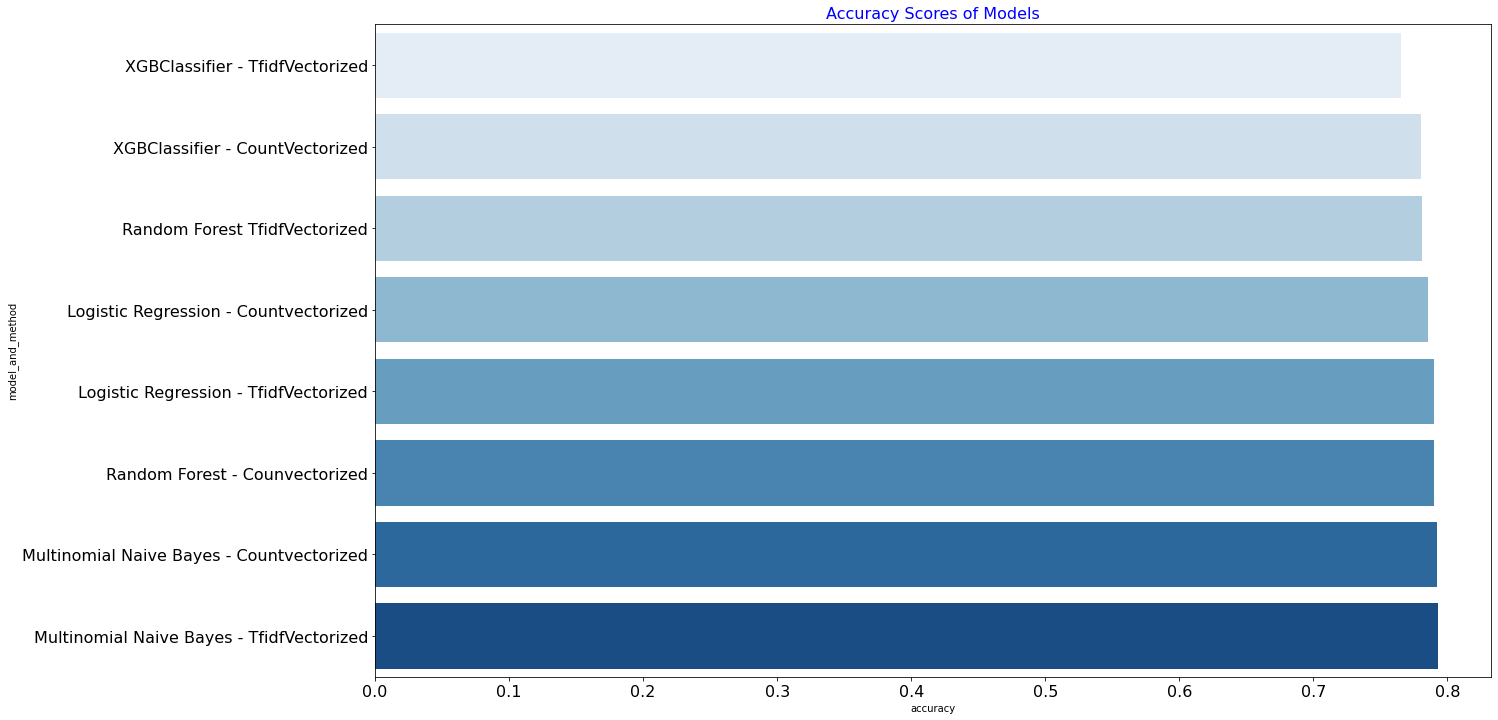

In [66]:
plt.figure(figsize=(20,12))

sns.barplot(x="accuracy", y="model_and_method", data=final_df_accuracy, palette="Blues")

plt.title("Accuracy Scores of Models", c="blue", size=16)
plt.yticks(size=16)
plt.xticks(size=16);

##### F1 Score

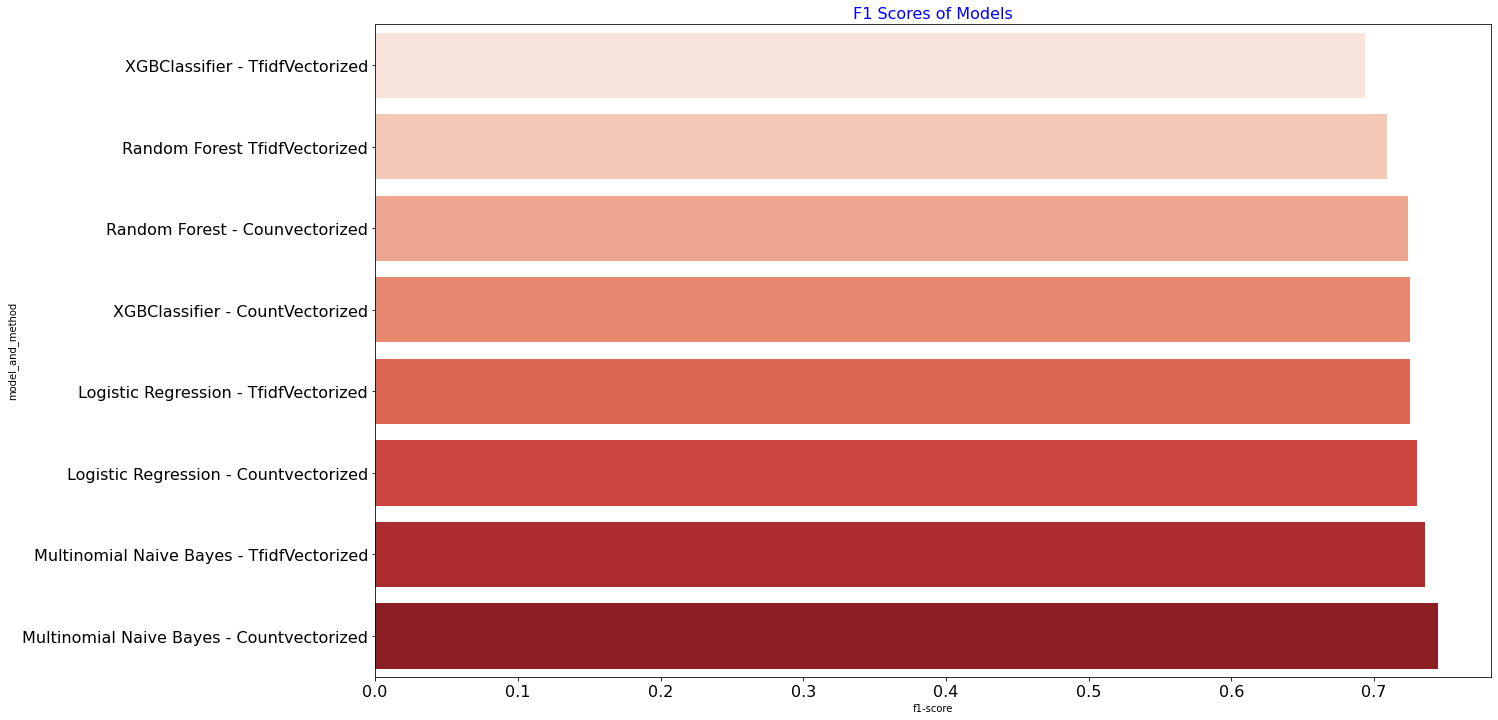

In [67]:
plt.figure(figsize=(20,12))

sns.barplot(x="f1-score", y="model_and_method", data=final_df_f1_score, palette="Reds")

plt.title("F1 Scores of Models", c="blue", size=16)
plt.yticks(size=16)
plt.xticks(size=16);

In [68]:
nbc= MultinomialNB(alpha=3, fit_prior=True)
nbc.fit(X_train_cov, y_train)
y_pred_nb_cov = nbc.predict(X_test_cov)
print(confusion_matrix(y_test, y_pred_nb_cov))
print("*****")
print(classification_report(y_test, y_pred_nb_cov))

[[932 159]
 [220 593]]
*****
              precision    recall  f1-score   support

           0       0.81      0.85      0.83      1091
           1       0.79      0.73      0.76       813

    accuracy                           0.80      1904
   macro avg       0.80      0.79      0.79      1904
weighted avg       0.80      0.80      0.80      1904



In [69]:
import pickle
pickle.dump(nbc, open("disastertweetsmodel", "wb"))

In [71]:
pickle.dump(countvect, open("countvectorizer", "wb"))